# Natural Language Processing with DistilBERT for Disaster Tweet Classification

## Project Overview
In this project, we'll build a machine learning model that can identify whether a tweet is about a real disaster or not. This is an important application of NLP that could help emergency responders identify real emergencies from social media data.

### Dataset
- 10,000 hand-classified tweets
- Binary classification task (disaster vs. non-disaster)
- Features include tweet text, keywords, and location information

### Technical Approach
We're using **DistilBERT**, a lightweight and efficient transformer model:
- 40% smaller than BERT
- 60% faster processing
- Maintains 97% of BERT's performance
- Perfect for real-world applications where efficiency matters

### What is BERT?
**BERT** (Bidirectional Encoder Representations from Transformers) revolutionized NLP by:
- Processing text bidirectionally (understanding context from both directions)
- Pre-training on massive text datasets
- Providing rich contextual word embeddings
- Supporting fine-tuning for specific tasks

![BERT Architecture](https://www.cse.chalmers.se/~richajo/nlp2019/l5/bert_class.png)

### Notebook Contents
1. Data Loading & Exploration
2. Text Preprocessing
3. Model Setup (DistilBERT)
4. Training Pipeline
5. Evaluation & Results
6. Prediction Generation

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim

from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
)


from datasets import Dataset

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import matplotlib.pyplot as plt

# Data Loading and Initial Exploration

Our dataset contains tweets that have been manually classified. Let's understand its structure:

### Features
1. **id**: Unique identifier for each tweet
2. **keyword**: A keyword extracted from the tweet (may be empty)
3. **location**: The location the tweet was sent from (may be empty)
4. **text**: The actual content of the tweet
5. **target**: Our label
   - 1 = Real disaster tweet
   - 0 = Not a real disaster tweet

### Why these features matter:
- **keywords**: Often indicate the topic/emergency type
- **location**: Could show geographical patterns in disaster reporting
- **text**: Contains the main information we'll use for classification

We'll load both training and test sets to begin our analysis.

In [3]:
df_train = pd.read_csv("Data/train.csv")
df_test = pd.read_csv("Data/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.161697
std        33.854073
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.241189
std        34.052153
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


If you want to know more information about the data, you can grab useful information [here](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)

Note that all the tweets are in english.

# Data Preprocessing and Model Setup

### Hyperparameters
- **BATCH_SIZE = 32**: Standard batch size for transformer models
- **VAL_SPLIT = 0.2**: 80% training, 20% validation split
- **MAX_LENGTH = 160**: Maximum tweet length (in tokens)
- **MODEL_NAME = "distilbert-base-uncased"**: Pre-trained model we'll fine-tune

### Data Processing Pipeline
1. Split data into train/validation sets
2. Convert to HuggingFace Datasets format
3. Tokenize text using DistilBERT tokenizer
4. Create PyTorch DataLoaders

The tokenization process converts text into numbers that the model can understand:
- Splits text into tokens (subwords)
- Adds special tokens ([CLS], [SEP])
- Pads sequences to same length
- Creates attention masks

In [7]:
BATCH_SIZE = 32
VAL_SPLIT  = 0.2
MAX_LENGTH = 160
MODEL_NAME = "distilbert-base-uncased"

In [8]:
from sklearn.model_selection import train_test_split

# stratified split
train_df, val_df = train_test_split(
    df_train,
    test_size=VAL_SPLIT,
    random_state=42,
    stratify=df_train["target"],
)

# Model Training

### Training Configuration
- **Model**: DistilBERT with binary classification head
- **Loss**: CrossEntropyLoss (standard for classification)
- **Optimizer**: AdamW with learning rate 1e-5
- **Epochs**: 2 full passes through the training data

### Training Process
For each epoch, we:
1. Set model to training mode
2. Process mini-batches of data
3. Compute loss and gradients
4. Update model parameters
5. Track and display average loss

### What to Watch For
- Decreasing loss values indicate learning
- Too rapid decrease might suggest overfitting
- Stable loss suggests good learning rate

The training loop includes proper handling of:
- GPU acceleration (if available)
- Gradient computation and updates
- Batch processing
- Loss tracking


In [9]:
# wrap pandas DataFrames in HF Dataset
train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)
test_ds  = Dataset.from_pandas(df_test)

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
    )

# apply tokenization
train_ds = train_ds.map(tokenize_batch, batched=True)
val_ds   = val_ds.map(tokenize_batch, batched=True)
test_ds  = test_ds.map(tokenize_batch, batched=True)

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [10]:
print("Train columns:", train_ds.column_names)
print("Train columns:", val_ds.column_names)
print("Train columns:", test_ds.column_names)

Train columns: ['id', 'keyword', 'location', 'text', 'target', 'length', '__index_level_0__', 'input_ids', 'attention_mask']
Train columns: ['id', 'keyword', 'location', 'text', 'target', 'length', '__index_level_0__', 'input_ids', 'attention_mask']
Train columns: ['id', 'keyword', 'location', 'text', 'length', 'input_ids', 'attention_mask']


# Rename, Format & Build DataLoaders


In [11]:
# Columns we’d like to drop
drop_cols = ["__index_level_0__", "length"]

# Remove from train & val
train_ds = train_ds.remove_columns([c for c in drop_cols if c in train_ds.column_names])
val_ds   = val_ds.remove_columns(  [c for c in drop_cols if c in val_ds.column_names])
test_ds  = test_ds.remove_columns( [c for c in drop_cols if c in test_ds.column_names])

# Rename 'target' → 'labels' (only train/val have it)
if "target" in train_ds.column_names:
    train_ds = train_ds.rename_column("target", "labels")
if "target" in val_ds.column_names:
    val_ds   = val_ds.rename_column("target", "labels")

In [12]:
def convert_to_torch_features(batch):
    return {
        'input_ids': torch.tensor(batch['input_ids']),
        'attention_mask': torch.tensor(batch['attention_mask']),
        'labels': torch.tensor(batch['labels']) if 'labels' in batch else None
    }

In [13]:
from torch.utils.data.dataloader import default_collate
from torch.utils.data import DataLoader
import torch

# Convert features to PyTorch format and select only the columns we need
train_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_ds.set_format('torch', columns=['input_ids', 'attention_mask'])

# Simple collate function
def collate_fn(examples):
    input_ids = torch.stack([x['input_ids'] for x in examples])
    attention_mask = torch.stack([x['attention_mask'] for x in examples])
    if 'labels' in examples[0]:
        labels = torch.tensor([x['labels'] for x in examples])
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}
    return {'input_ids': input_ids, 'attention_mask': attention_mask}

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Temporarily disable multiprocessing
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

# Steps per Epoch (optional)

In [14]:
steps_per_epoch = len(train_loader)
print("Batches per epoch:", steps_per_epoch)

Batches per epoch: 191


# Load a DistilBERT model from Keras NLP

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.

The BertClassifier model can be configured with a preprocessor layer, in which case it will automatically apply preprocessing to raw inputs during fit(), predict(), and evaluate(). This is done by default when creating the model with from_preset().

We will choose DistilBERT model.that learns a distilled (approximate) version of BERT, retaining 97% performance but using only half the number of parameters ([paper](https://arxiv.org/abs/1910.01108)). 

It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

Specifically, it doesn't have token-type embeddings, pooler and retains only half of the layers from Google's BERT.

In [15]:
MODEL_NAME = "distilbert-base-uncased"

# 1) Tokenizer (handles tokenization + attention mask)
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

# 2) Pretrained classifier head on top of DistilBERT
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,            # your binary task
)

# 3) Try to use DirectML for AMD GPU, fallback to CPU if not available
try:
    import torch_directml
    dml = torch_directml.device()
    print(f"Using DirectML device: {dml}")
    device = dml
except Exception:
    device = torch.device("cpu")
    print(f"Falling back to CPU: {device}")
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using DirectML device: privateuseone:0


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


# Setup optimizer & loss

In [16]:
from torch.optim import AdamW

# Binary classification → use CrossEntropyLoss (expects raw logits)
criterion = torch.nn.CrossEntropyLoss()

# AdamW is standard for Transformers, but disable foreach for DirectML compatibility
optimizer = optim.AdamW(
    model.parameters(), 
    lr=1e-5,
    foreach=False  # Disable foreach path to avoid CPU fallback
)

# Fine-tune DistilBERT

In [ ]:
EPOCHS = 2

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}/{EPOCHS} — loss: {avg_loss:.4f}")

c:\Users\samin\miniconda3\envs\nlp-env\lib\site-packages\torch\optim\adamw.py:380: UserWarning: The operator 'aten::lerp.Scalar_out' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  exp_avg.lerp_(grad, 1 - beta1)


# Model Evaluation

### Evaluation Metrics
We use several metrics to assess model performance:

1. **Confusion Matrix**
   - Shows True Positives, False Positives, True Negatives, False Negatives
   - Helps visualize where model makes mistakes

2. **F1 Score**
   - Harmonic mean of precision and recall
   - Balances false positives and false negatives
   - Particularly important for imbalanced datasets

### Prediction Process
The `get_predictions` function:
1. Sets model to evaluation mode
2. Disables gradient computation
3. Processes batches of data
4. Returns both true labels and predicted probabilities

### Visualization
The confusion matrix plot shows:
- Correct predictions on diagonal
- Errors off-diagonal
- Color intensity indicates frequency
- Labels for easy interpretation

In [ ]:
def get_predictions(loader):
    """Run model over a DataLoader and return (y_true, y_pred_probs)."""
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            # Move tensors to DirectML device individually
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch["labels"].to(device)
            
            # Forward pass
            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.softmax(logits, dim=-1)
            all_preds.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    return (
        np.concatenate(all_labels, axis=0),
        np.concatenate(all_preds,  axis=0),
    )

def display_confusion_matrix(y_true, y_pred_probs, dataset_name):
    y_pred = np.argmax(y_pred_probs, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Not Disaster","Disaster"],
    )
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix — {dataset_name}")
    plt.show()
    # Compute a simple F1:
    tp = cm[1,1]
    fp = cm[0,1]
    fn = cm[1,0]
    f1 = tp / (tp + (fp+fn)/2)
    print(f"{dataset_name} F1 score: {f1:.2f}\n")

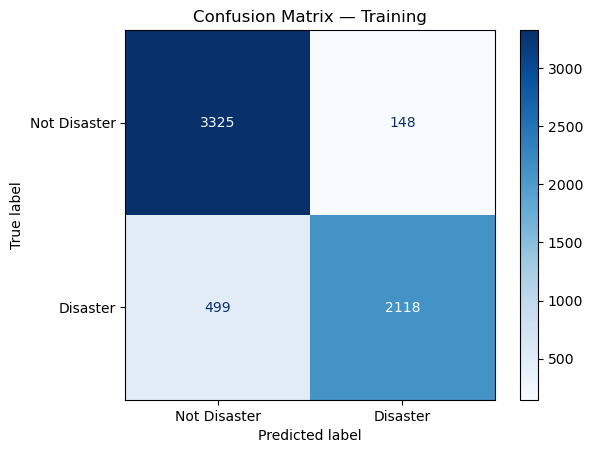

Training F1 score: 0.87



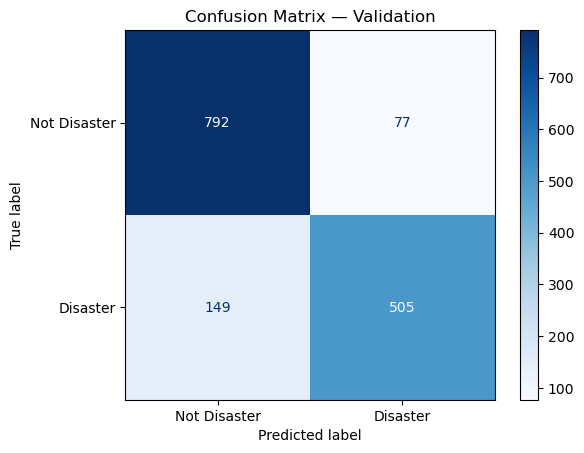

Validation F1 score: 0.82



In [19]:
# Cell: Evaluate
y_train, p_train = get_predictions(train_loader)
display_confusion_matrix(y_train, p_train, "Training")

y_val, p_val = get_predictions(val_loader)
display_confusion_matrix(y_val, p_val, "Validation")